# Visualization

## 0. Model & Data load

In [1]:
# ── 환경 설정 ──
import sys, os
sys.path.insert(0, os.path.abspath('..'))   # project root → model.py, utils.py
sys.path.insert(0, os.path.abspath('.'))    # figure dir  → figutils/

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

from figutils.common import load_model, load_composite_data, make_dataloader
print('✓ Environment ready')

✓ Environment ready


In [2]:
# ── 설정 (필요에 따라 수정) ──
CKPT_PATH   = '../ckpt.pt'
DATA_PATH   = '../data/kr_val.bin'
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE  = 32
BLOCK_SIZE  = 512
MAX_PATIENTS = 1000   # -1 = 전체

# 모델 로드
model, ckpt = load_model(CKPT_PATH, device=DEVICE)
print(f"  Best val loss : {ckpt.get('best_val_loss', 'N/A')}")
print(f"  Iteration     : {ckpt.get('iter_num', 'N/A')}")

# 데이터 & DataLoader
data_raw, data_2d, p2i = load_composite_data(DATA_PATH)
dataloader = make_dataloader(data_raw, p2i,
                             block_size=BLOCK_SIZE,
                             batch_size=BATCH_SIZE,
                             max_patients=MAX_PATIENTS)

[INFO] Loading model from ../ckpt.pt → cuda
[OK]  Model loaded (20.61M params)
  Best val loss : 8.046859741210938
  Iteration     : 6000
[INFO] Loading data from ../data/kr_val.bin
[OK]  3,597,081 events, 20,571 patients
[INFO] Limited to 1000 patients
[OK]  DataLoader: 32 batches (bs=32)


In [3]:
from figutils.performance import CompositeModelAnalyzer

analyzer = CompositeModelAnalyzer(model, device=DEVICE)
analyzer.collect_predictions(dataloader)

print(f"Shift predictions : {analyzer.predictions['shift'].shape}")
print(f"Total predictions : {analyzer.predictions['total'].shape}")

  10 batches processed
  20 batches processed
  30 batches processed
Prediction collection complete!
Shift predictions : torch.Size([1000, 512, 5])
Total predictions : torch.Size([1000, 512])


## 1. Performance & XAI

#### 1-1. Shift 분류 성능

[DEBUG] Raw prediction distribution:
    Non-Drug (idx=1):   20,684 (54.6%)
    Decrease (idx=2):      487 (1.3%)
    Maintain (idx=3):   16,713 (44.1%)
Shift analysis — 37,884 drug events
  Classes: {'Decrease': np.int64(3045), 'Maintain': np.int64(33293), 'Increase': np.int64(1546)}


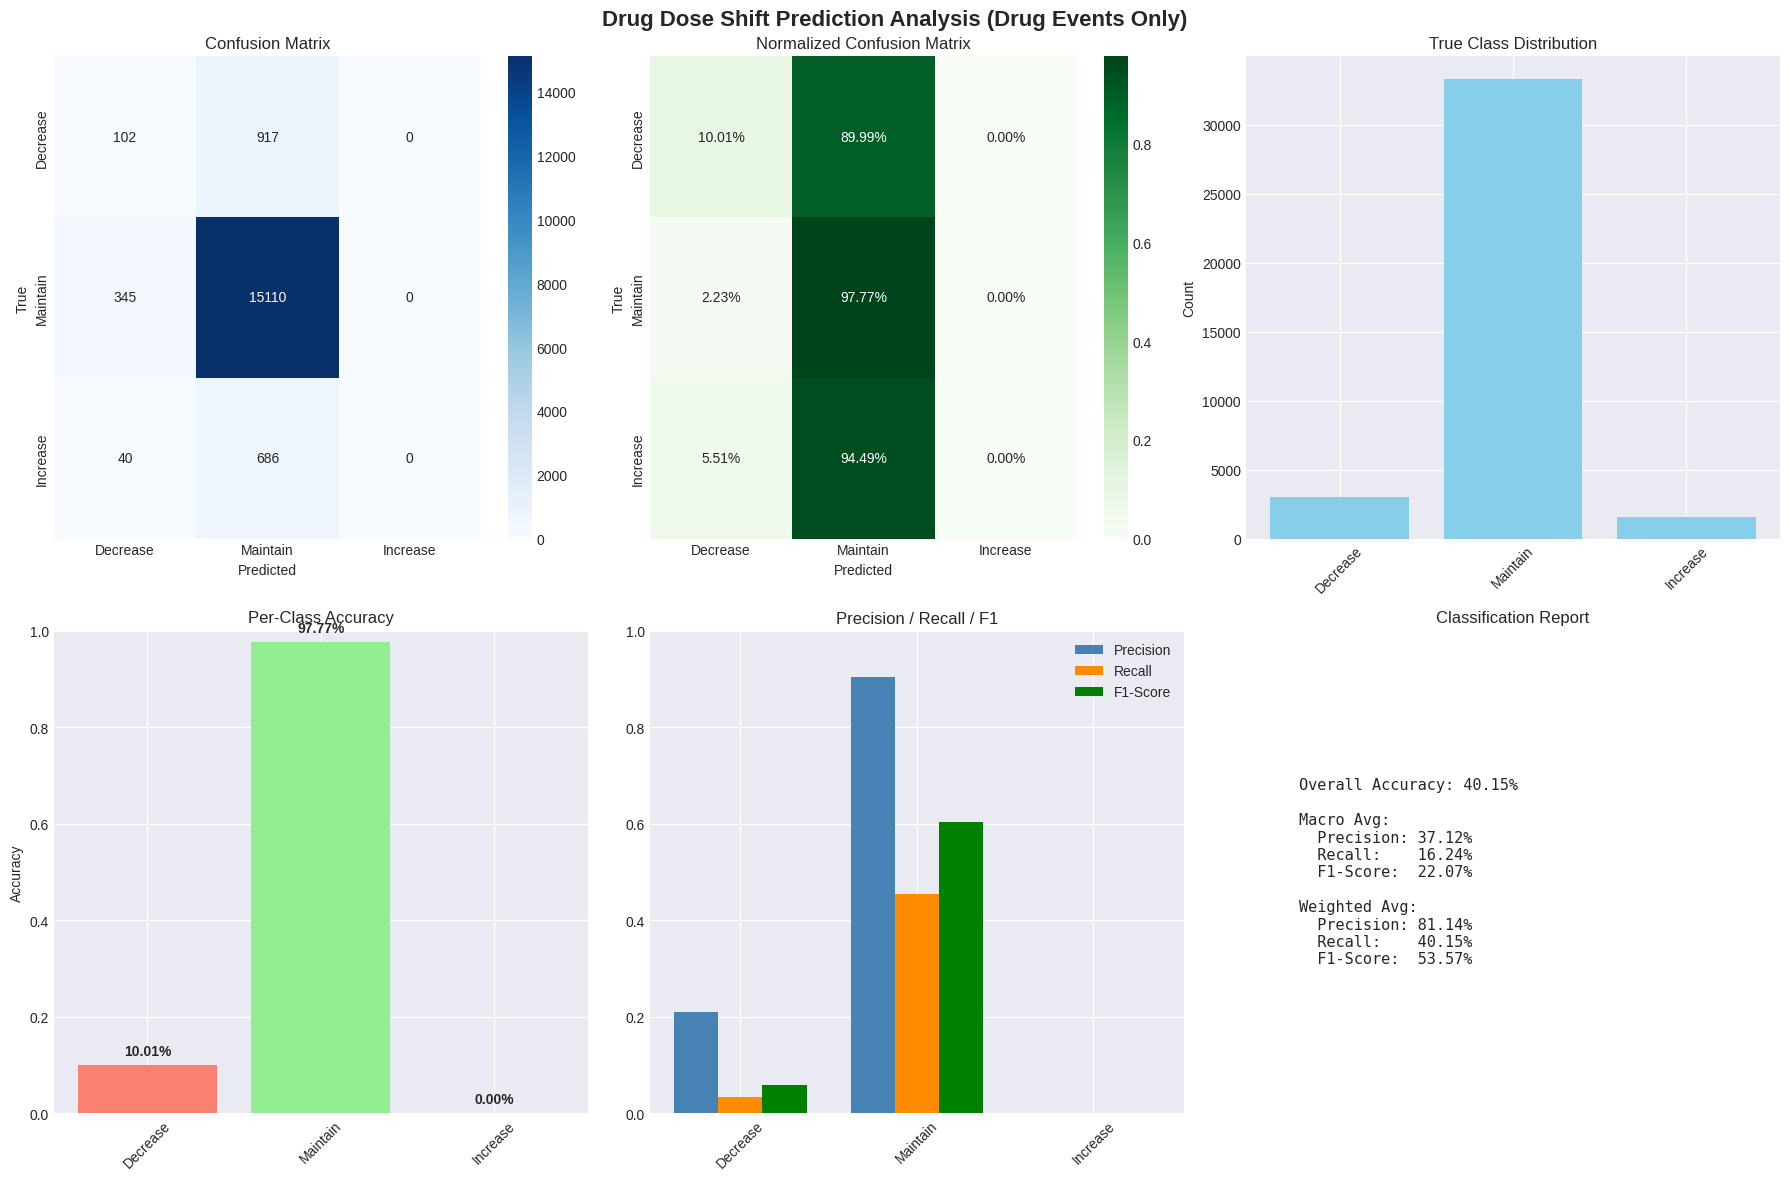

Overall Accuracy : 40.15%
  Decrease    P=0.209  R=0.033  F1=0.058
  Maintain    P=0.904  R=0.454  F1=0.604
  Increase    P=0.000  R=0.000  F1=0.000


In [4]:
shift_report = analyzer.visualize_shift_performance()
# shift_report = analyzer.visualize_shift_performance(save_path='shift_analysis.png')  # to save

print(f"Overall Accuracy : {shift_report['accuracy']:.2%}")
for cls in ['Decrease', 'Maintain', 'Increase']:
    if cls in shift_report:
        r = shift_report[cls]
        print(f"  {cls:10s}  P={r['precision']:.3f}  R={r['recall']:.3f}  F1={r['f1-score']:.3f}")

#### 1-2. Total 회귀 성능

Total analysis — 37,836 drug events


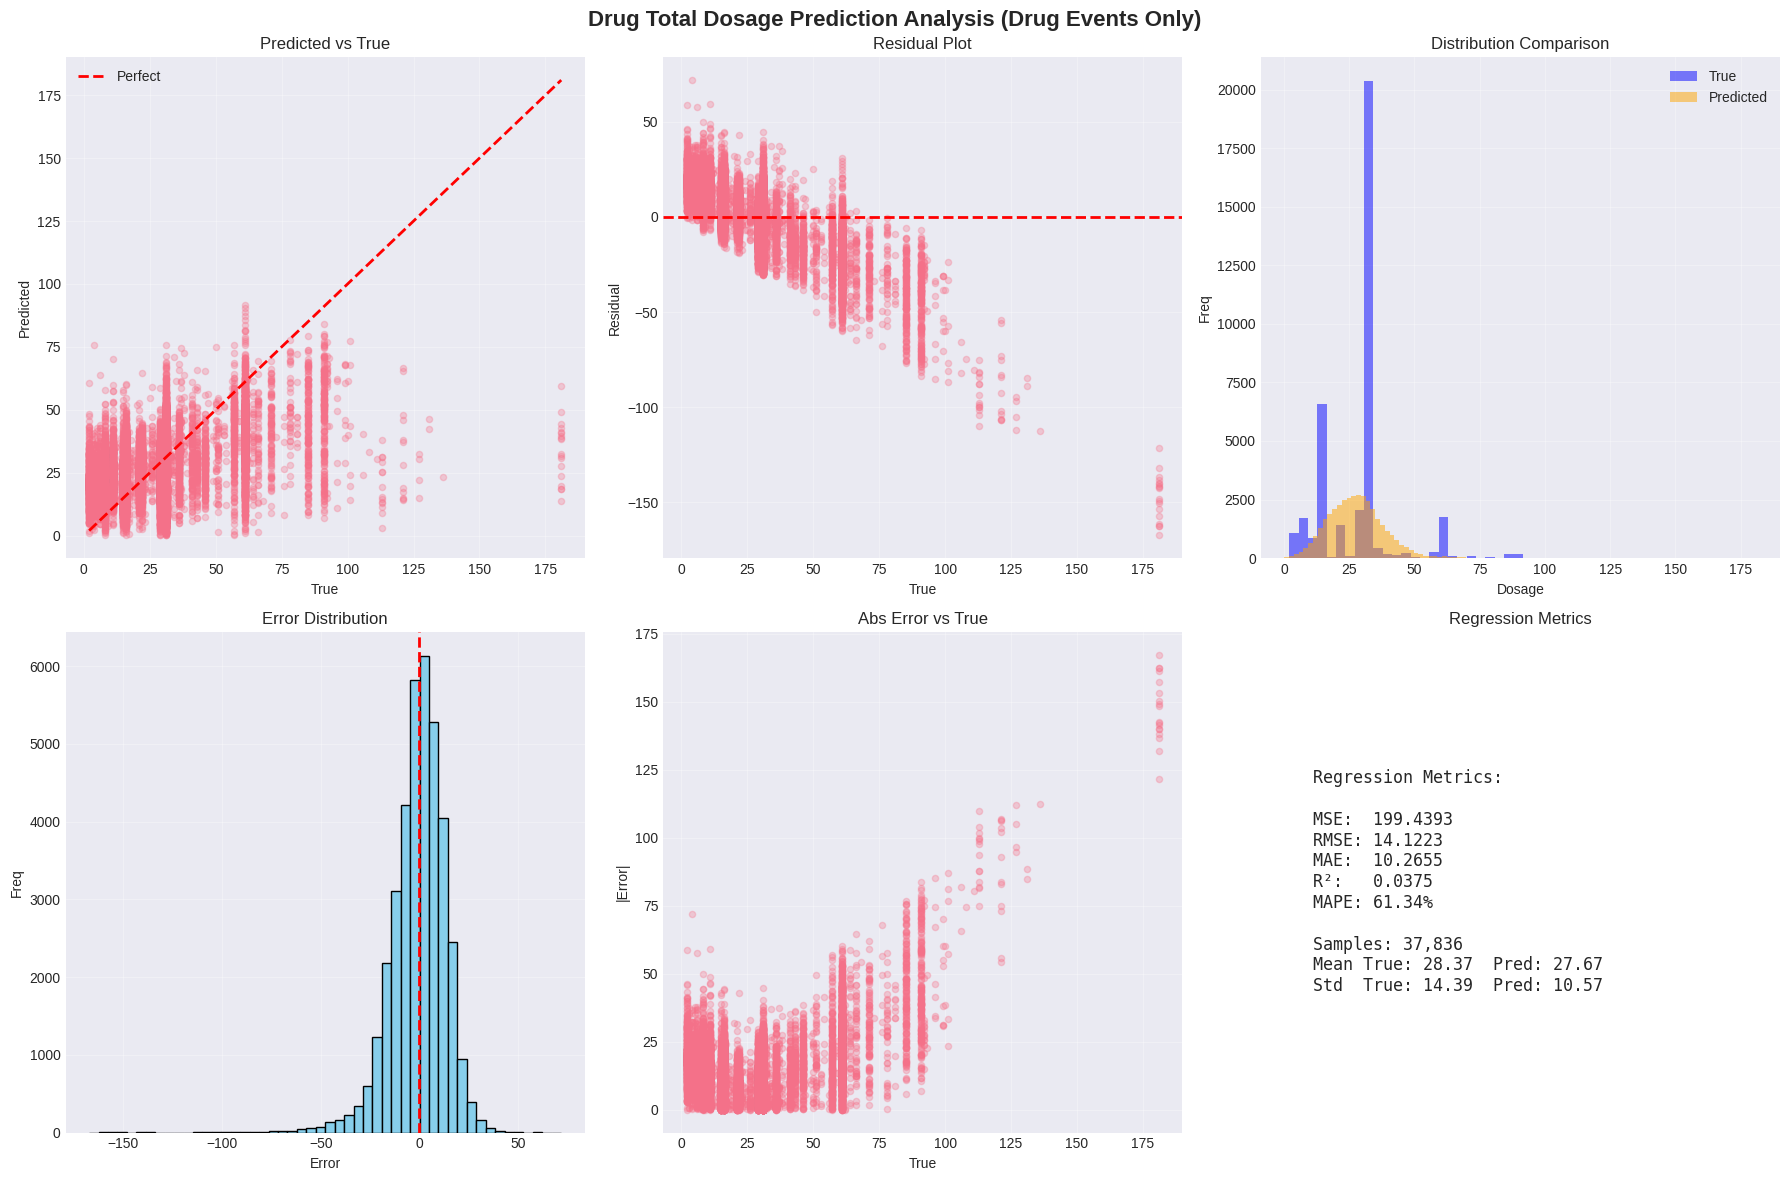

R²   : 0.037
RMSE : 14.12
MAE  : 10.27
MAPE : 61.34%


In [5]:
total_metrics = analyzer.visualize_total_performance()
# total_metrics = analyzer.visualize_total_performance(save_path='total_analysis.png')  # to save

print(f"R²   : {total_metrics['r2']:.3f}")
print(f"RMSE : {total_metrics['rmse']:.2f}")
print(f"MAE  : {total_metrics['mae']:.2f}")
print(f"MAPE : {total_metrics['mape']:.2f}%")

#### 1-3. Attention map

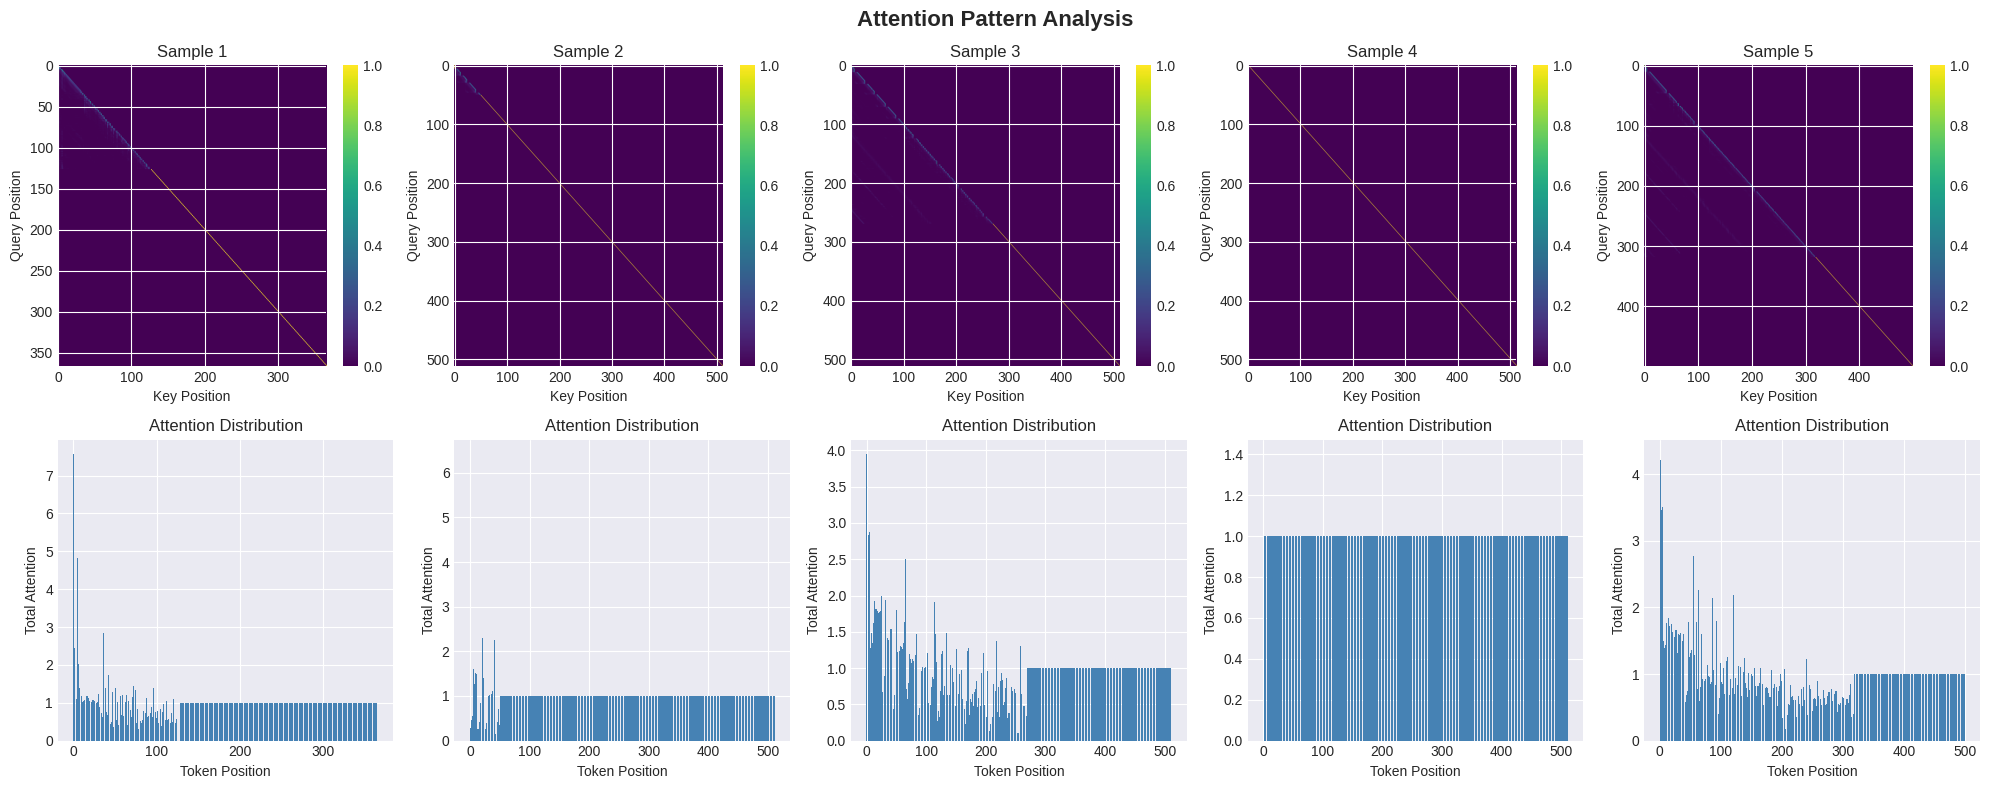

In [6]:
from figutils.xai import AdvancedXAIAnalyzer

xai = AdvancedXAIAnalyzer(model, device=DEVICE)

xai.visualize_attention_patterns(dataloader, num_samples=5)
# xai.visualize_attention_patterns(dataloader, num_samples=5, save_path='attention_patterns.png')  # to save

#### 1-4. Feature importance

Analyzing feature importance across dataset (token_type='drug')...
  Token coverage: 37,681 / 512,000 (7.4%)
  Token value range: 1277 ~ 1285
  Mean token value: 1280.6


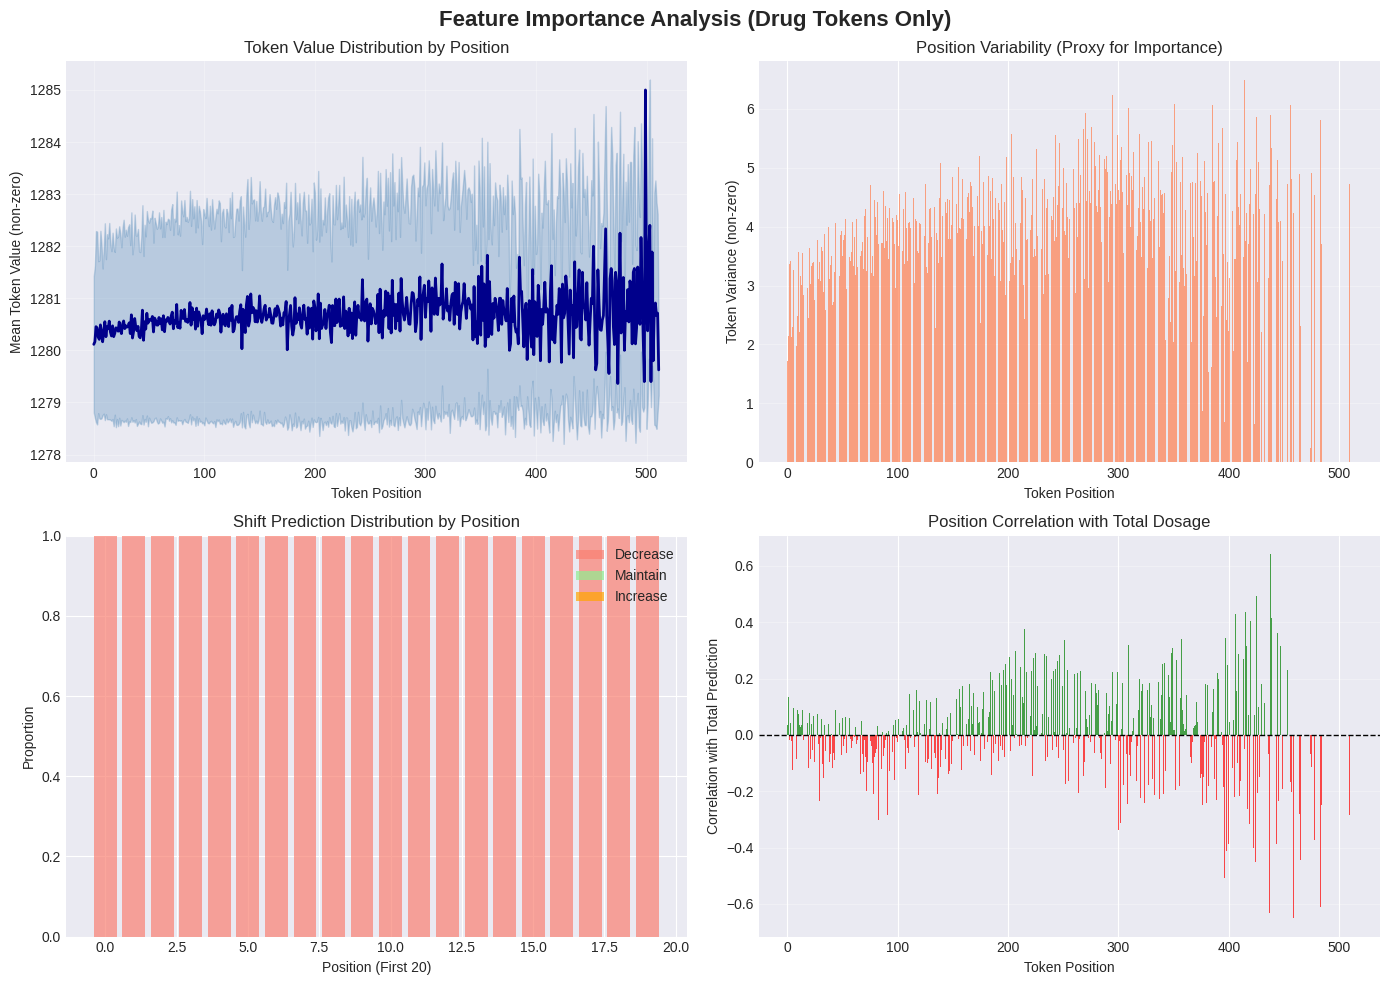

In [7]:
xai.create_feature_importance_analysis(dataloader, token_type='drug')
# xai.create_feature_importance_analysis(dataloader, save_path='feature_importance.png')  # to save

#### 1-5. Sample prediction

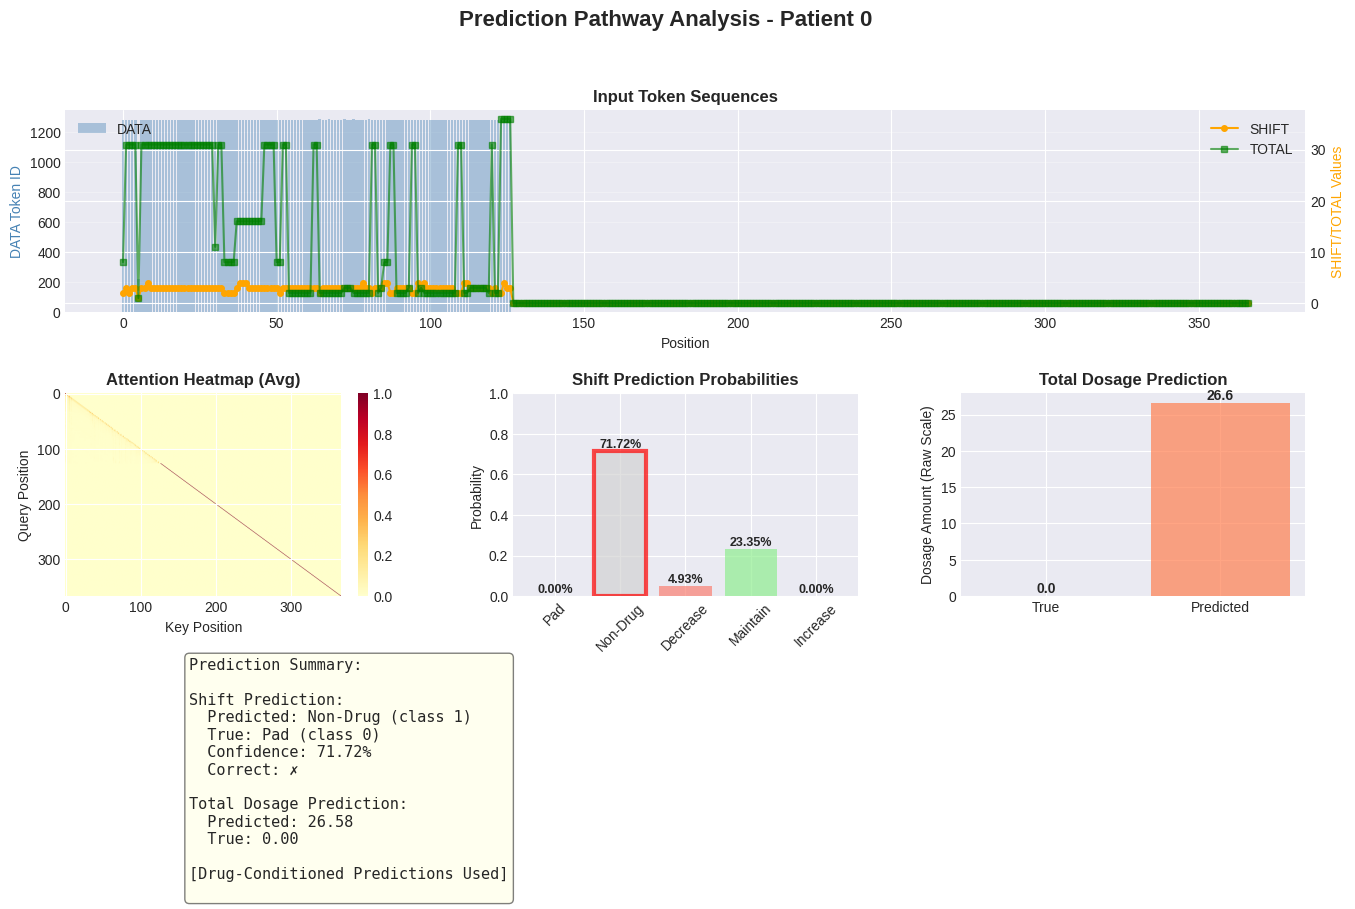

  ✓ Sample 0


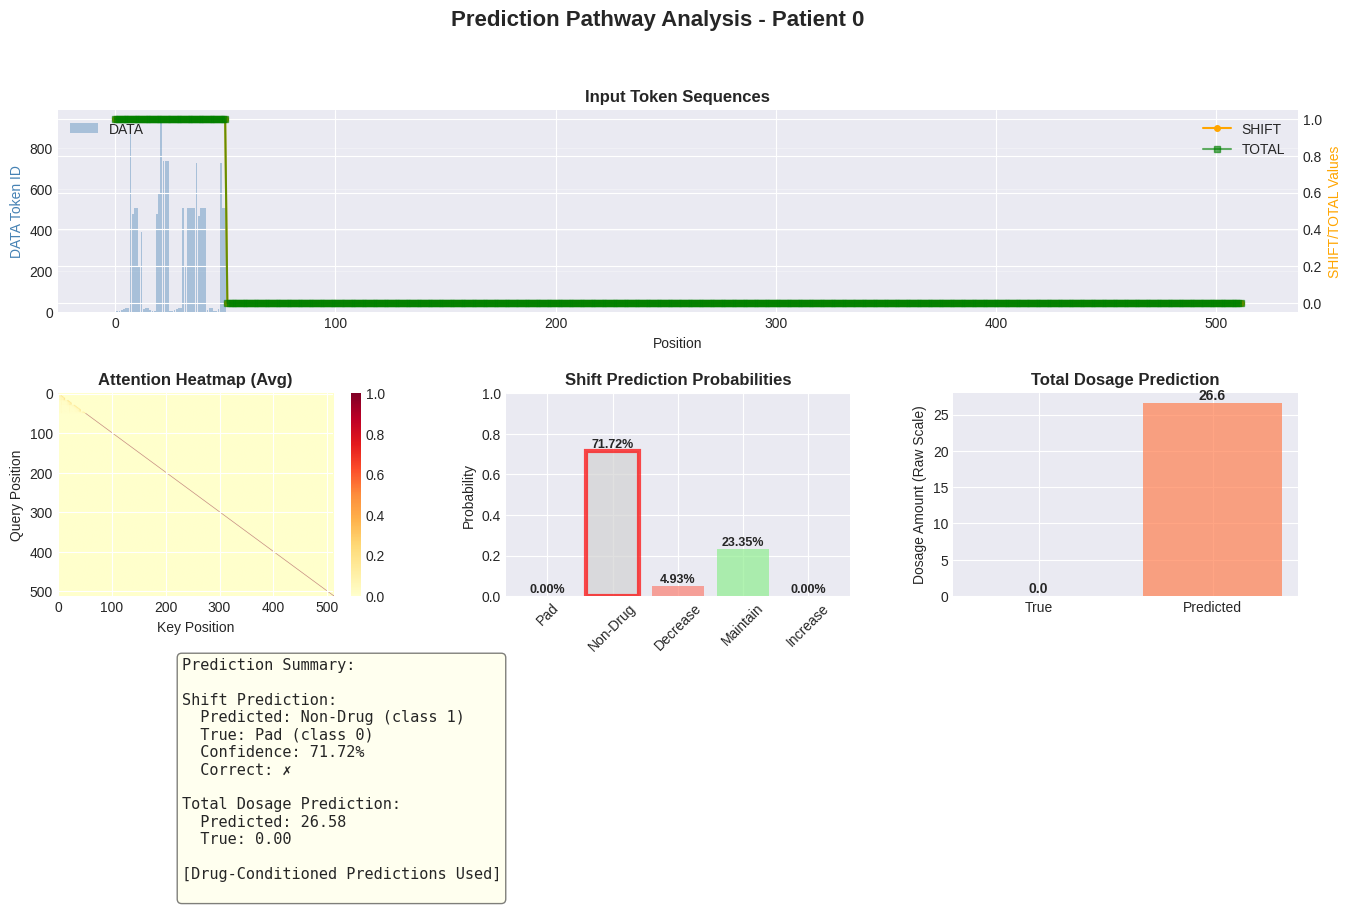

  ✓ Sample 1


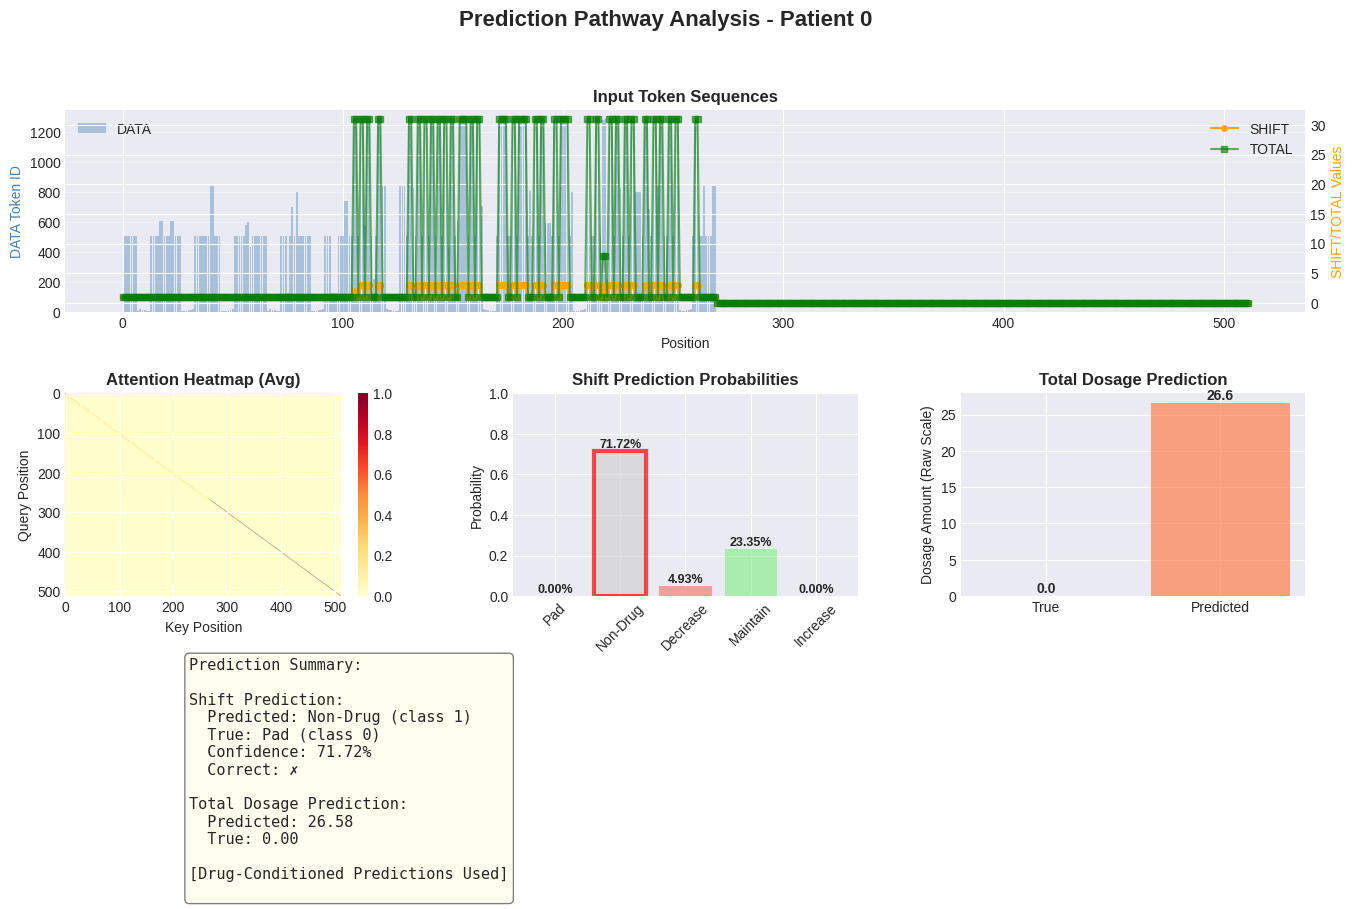

  ✓ Sample 2
Done.


In [8]:
for i, batch in enumerate(dataloader):
    if i >= 3:
        break
    xai.visualize_prediction_pathway(batch, sample_idx=0)
    # xai.visualize_prediction_pathway(batch, sample_idx=0, save_path=f'pathway_sample_{i}.png')  # to save
    print(f'  ✓ Sample {i}')

print('Done.')

## 2. Token embedding

#### 2-1. UMAP embedding

In [9]:
from figutils.umap_viz import (
    load_token_frequencies, load_chapter_metadata,
    get_embeddings, run_umap, draw_umap_plot
)

# 경로 설정
CKPT_PATH   = '../ckpt.pt'
LABELS_PATH = '../data/labels_chapter.csv'
TRAIN_BIN   = '../data/kr_train.bin'

# 라벨링할 토큰 ID
TARGET_IDS = [223,224,225,226,227,508,879,1177,
              1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289]

# 데이터 준비
token_counts = load_token_frequencies(TRAIN_BIN)
token_meta, legend_info = load_chapter_metadata(LABELS_PATH)
embeddings, valid_ids = get_embeddings(CKPT_PATH, token_meta)
umap_2d = run_umap(embeddings, n_neighbors=15, min_dist=0.1)

[INFO] Computing token frequencies from: ../data/kr_train.bin
[OK]  1156 unique tokens
[INFO] Loading chapter metadata from: ../data/labels_chapter.csv
[INFO] Loading embeddings from ../ckpt.pt
[INFO] Running UMAP...


[INFO] Rendering UMAP scatter plot...


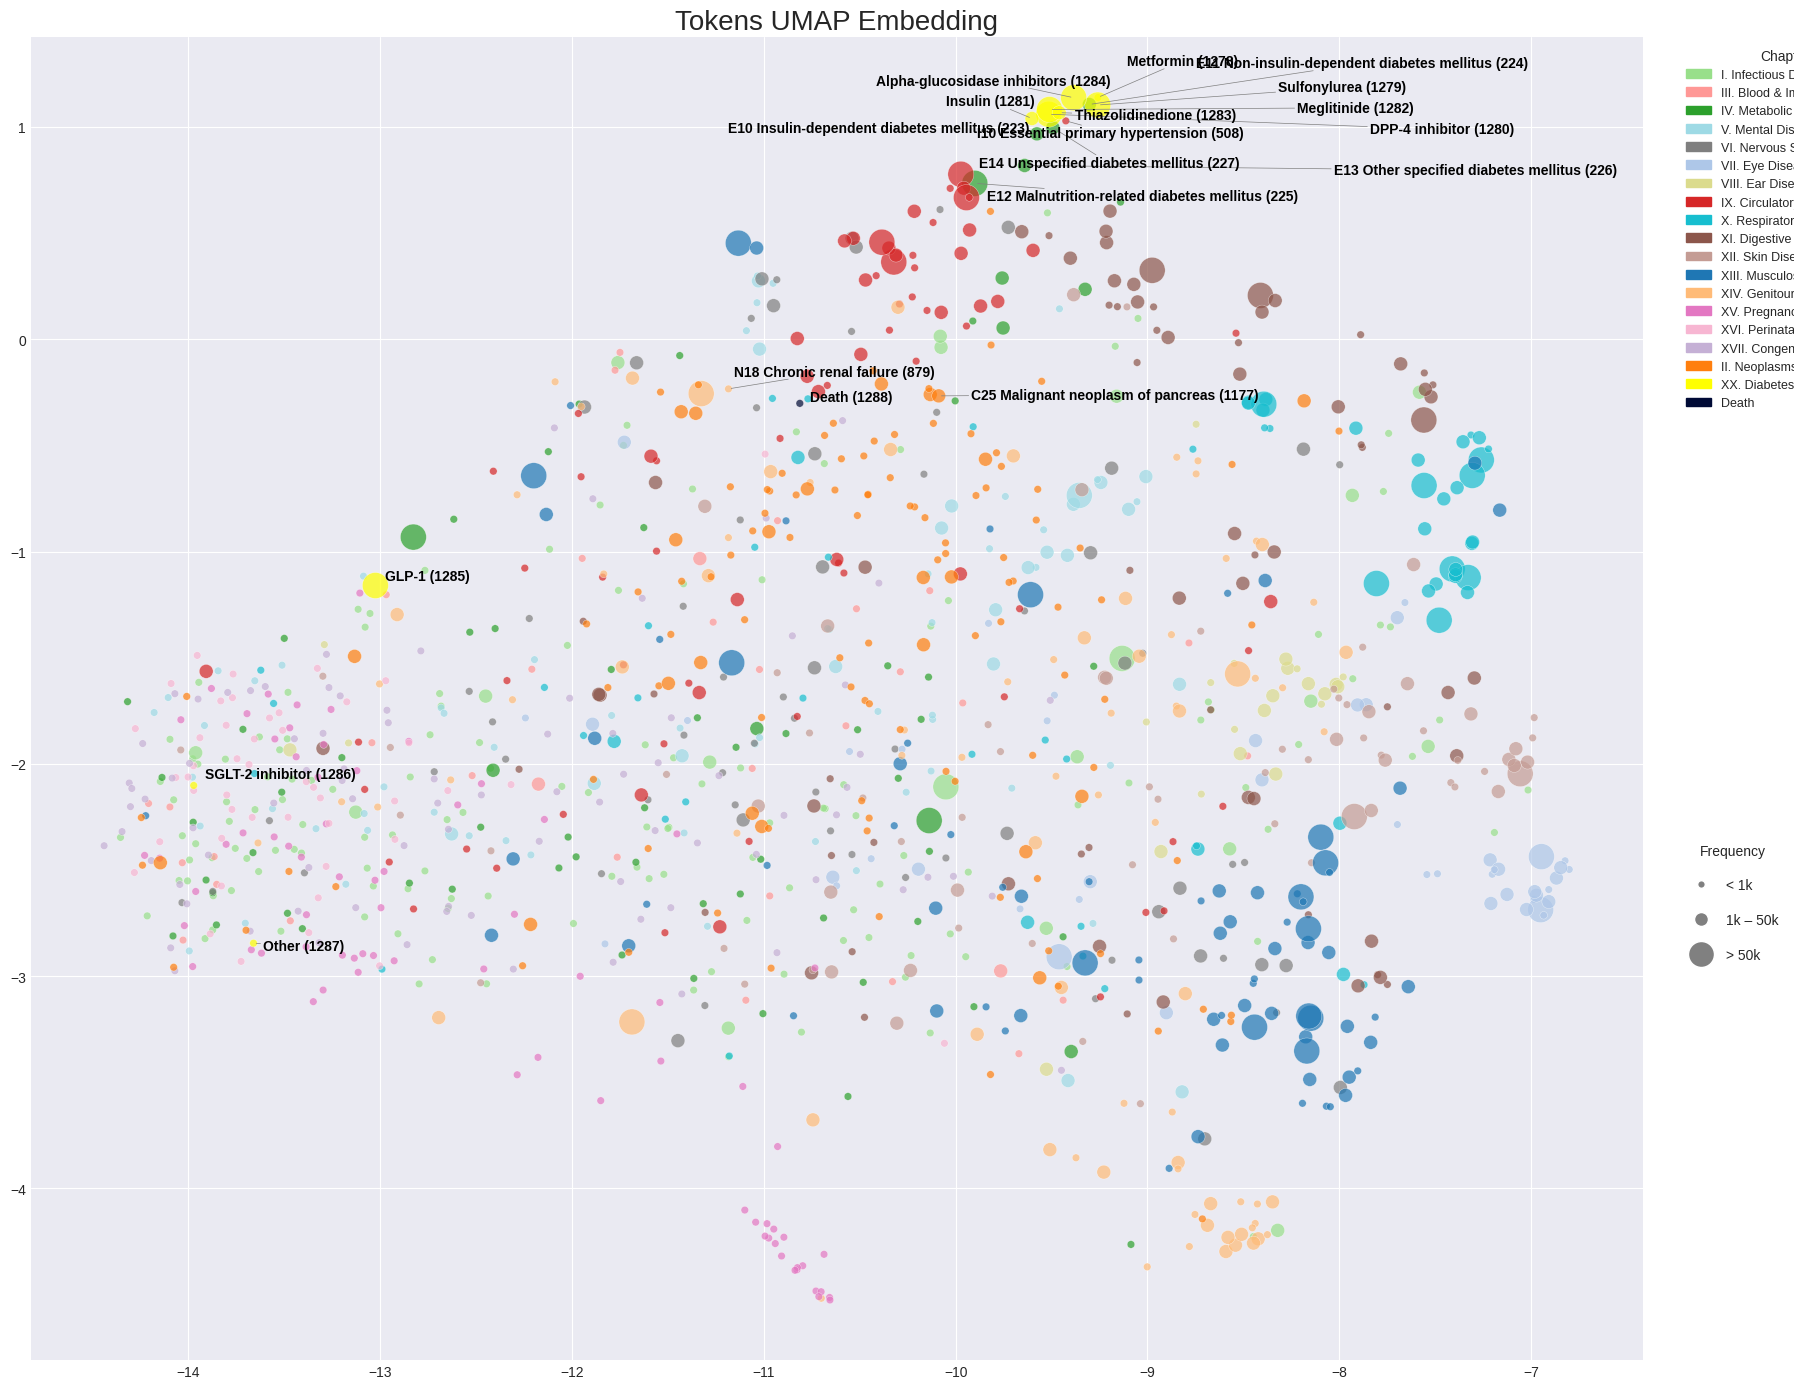

In [10]:
fig = draw_umap_plot(
    umap_2d, valid_ids, token_meta, token_counts, legend_info,
    target_label_ids=TARGET_IDS,
)
# fig.savefig('umap_embedding.png', dpi=300, bbox_inches='tight')  # to save
plt.show()

#### 2-2. AUC boxplot

In [11]:
from figutils.boxplot import (
    DATASET_MAP, load_chapter_metadata as load_chap_box,
    load_dataset, draw_boxplot
)

LABELS_PATH = '../data/labels_chapter.csv'
RESULT_DIR  = '../results'

chapter_df, palette = load_chap_box(LABELS_PATH)

[INFO] Loading metadata from: ../data/labels_chapter.csv


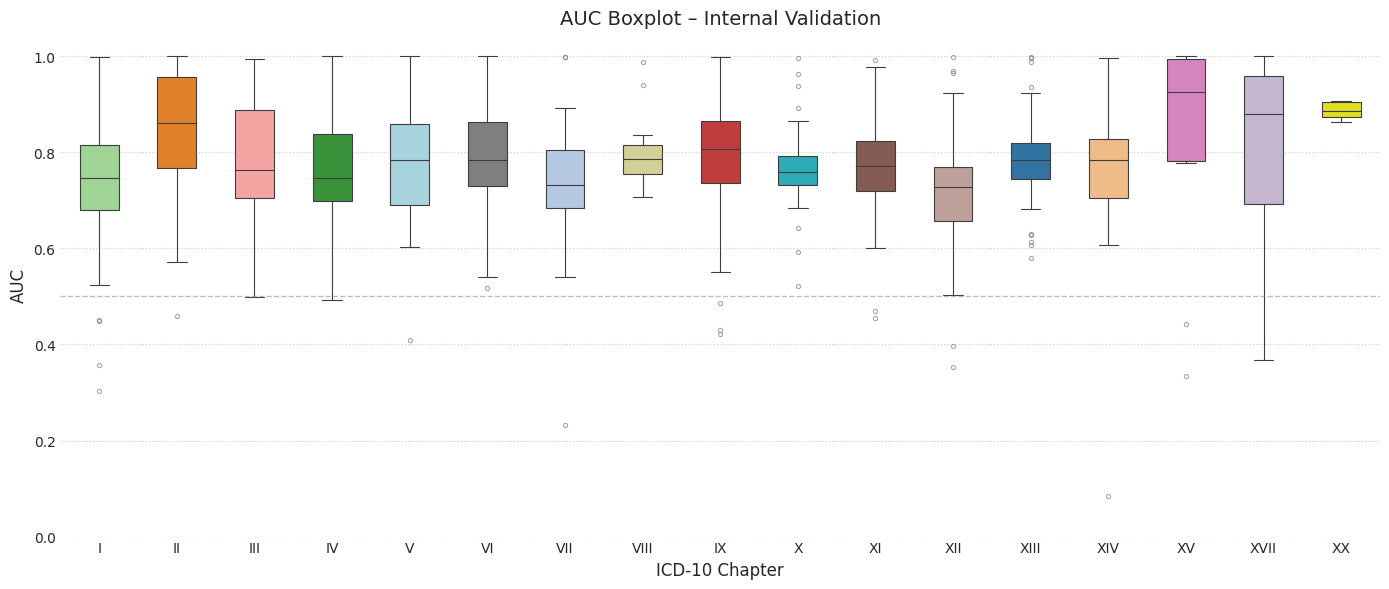

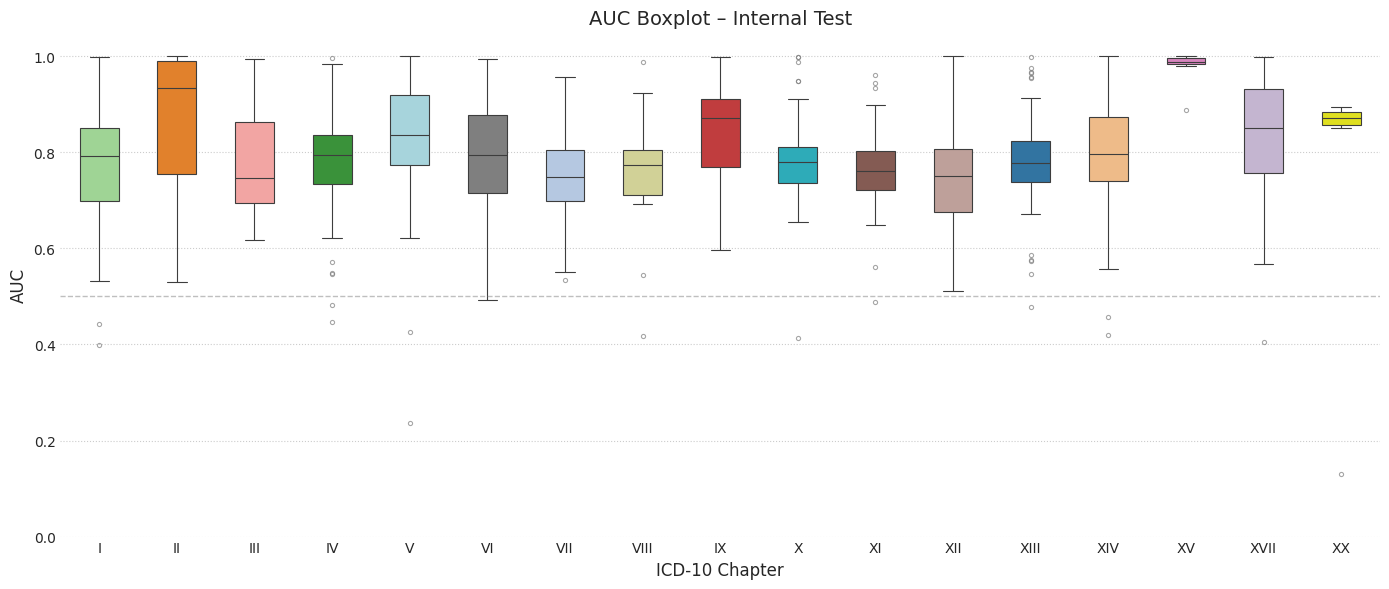

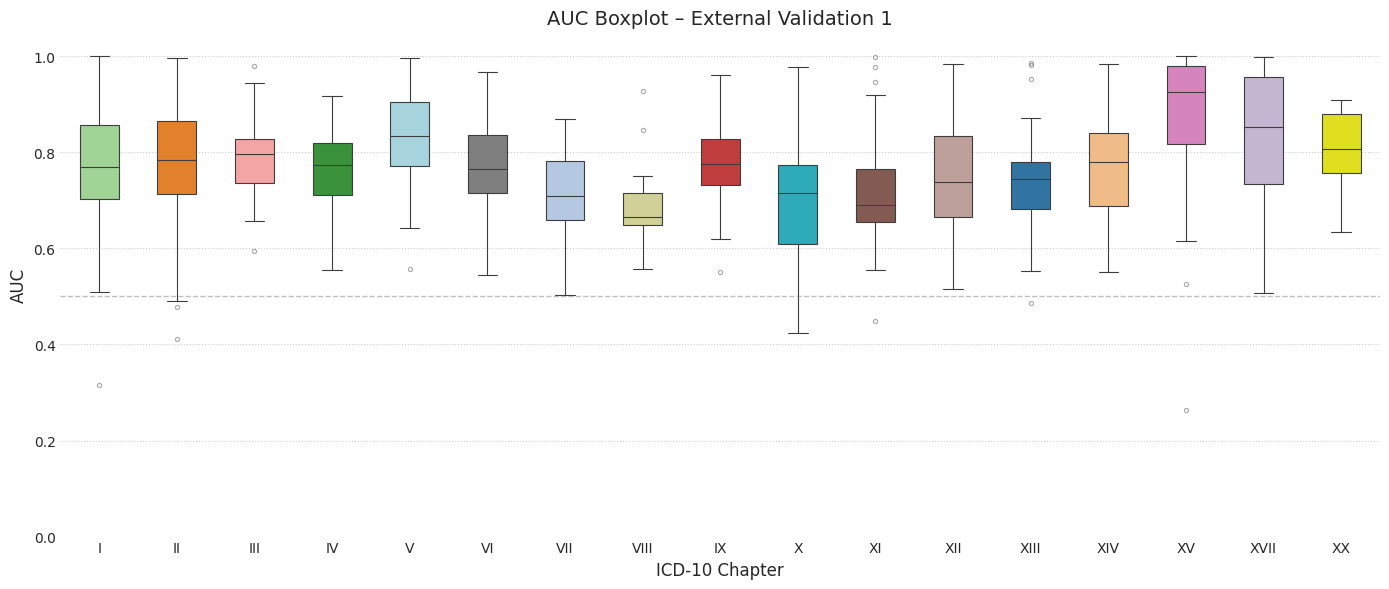

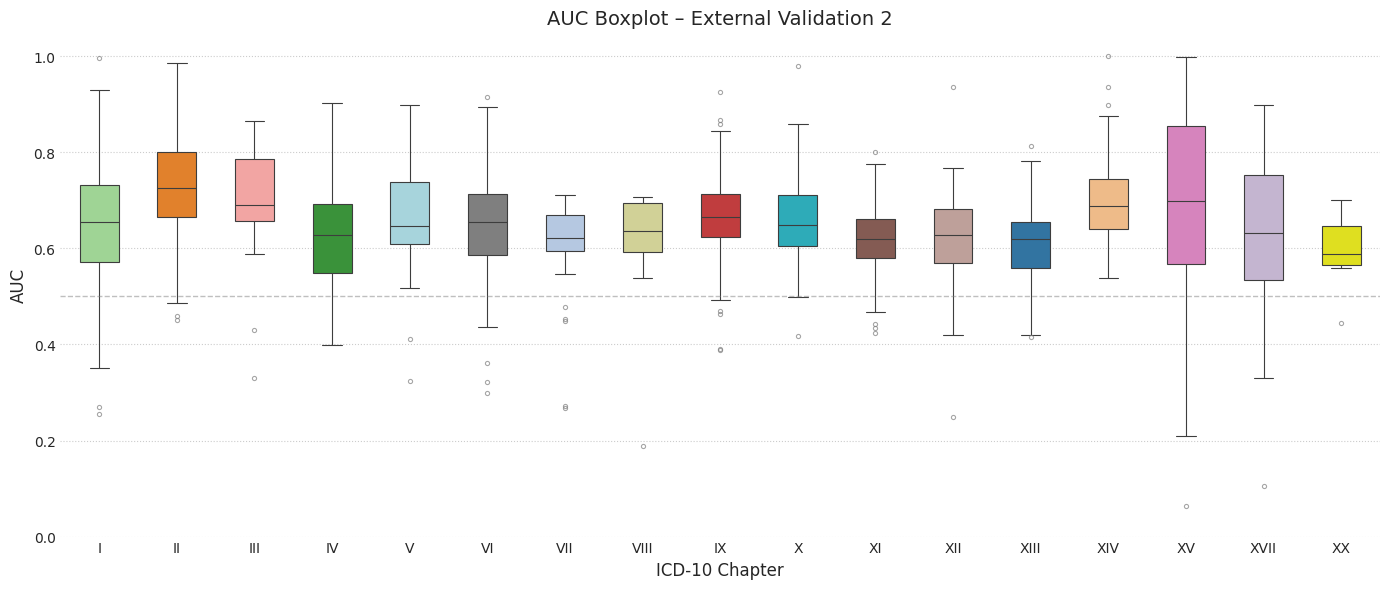

In [12]:
for key in DATASET_MAP:
    title, fname = DATASET_MAP[key]
    df = load_dataset(RESULT_DIR, fname, chapter_df)
    if df is not None and not df.empty:
        fig = draw_boxplot(df, palette, title=f'AUC Boxplot – {title}')
        # fig.savefig(f'boxplot_{key}.png', dpi=300, bbox_inches='tight')  # to save
        plt.show()
    else:
        print(f'[SKIP] {key}')

## 3. SHAP analysis

#### 3-1. Waiting time (Expected vs Obseved)

[INFO] Loading model from ../ckpt.pt → cuda
[OK]  Model loaded (20.61M params)
[INFO] Loading data from ../data/kr_val.bin
[OK]  3,597,081 events, 20,571 patients
[INFO] Running inference for waiting times...
[OK]  19,638 valid token predictions


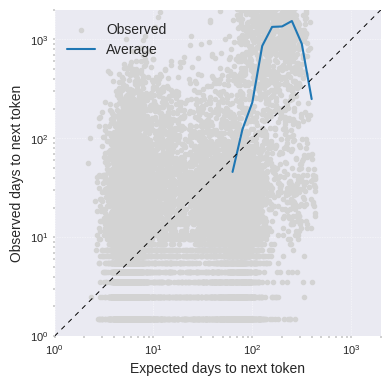

In [4]:
import torch
from figutils.common import load_model, load_composite_data
from figutils.event import compute_waiting_times, compute_binned_averages, draw_waiting_time_plot

CKPT_PATH = '../ckpt.pt'
DATA_PATH = '../data/kr_val.bin'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model, _ = load_model(CKPT_PATH, device=DEVICE)
val_raw, _, val_p2i = load_composite_data(DATA_PATH)

expected_t, t_observed = compute_waiting_times(
    model, val_raw, val_p2i, DEVICE,
    batch_indices=range(256), block_size=128
)

bin_centers, bin_means = compute_binned_averages(expected_t, t_observed)
                                                                                                      
fig = draw_waiting_time_plot(expected_t, t_observed, bin_centers, bin_means)
# fig.savefig('waiting_time.png', dpi=300, bbox_inches='tight')  # to save
plt.show()

#### 3-2. SHAP Analysis

In [14]:
from figutils.shap_viz import (
    load_shap_data, process_shap_matrix,
    draw_full_heatmap, draw_focused_heatmap,
    draw_top_interactions, draw_chapter_to_chapter,
    draw_death_risk_factors, draw_shap_distribution
)

shap_info = load_shap_data(
    shap_pickle_path='../shap_agg_composite.pickle',
    labels_csv_path='../data/labels_chapter.csv'
)

matrix_info = process_shap_matrix(
    shap_info,
    exclude_chapters=['Sex', 'Smoking, Alcohol and BMI', 'Technical'],
    min_occurrences=5,
    death_token_id=1288,
    death_repeat=10
)

Loading SHAP data...
Total tokens: 3507807
SHAP values shape: (3507807, 1290)

Processing SHAP matrix...
Computing SHAP effects...


100%|██████████| 3507807/3507807 [09:14<00:00, 6329.34it/s]


#### 3-3. SHAP visualizations


Creating Full Interaction Heatmap (log scale)...
Expanding Death column: 10x
Original: (839, 840) → Expanded: (839, 849)


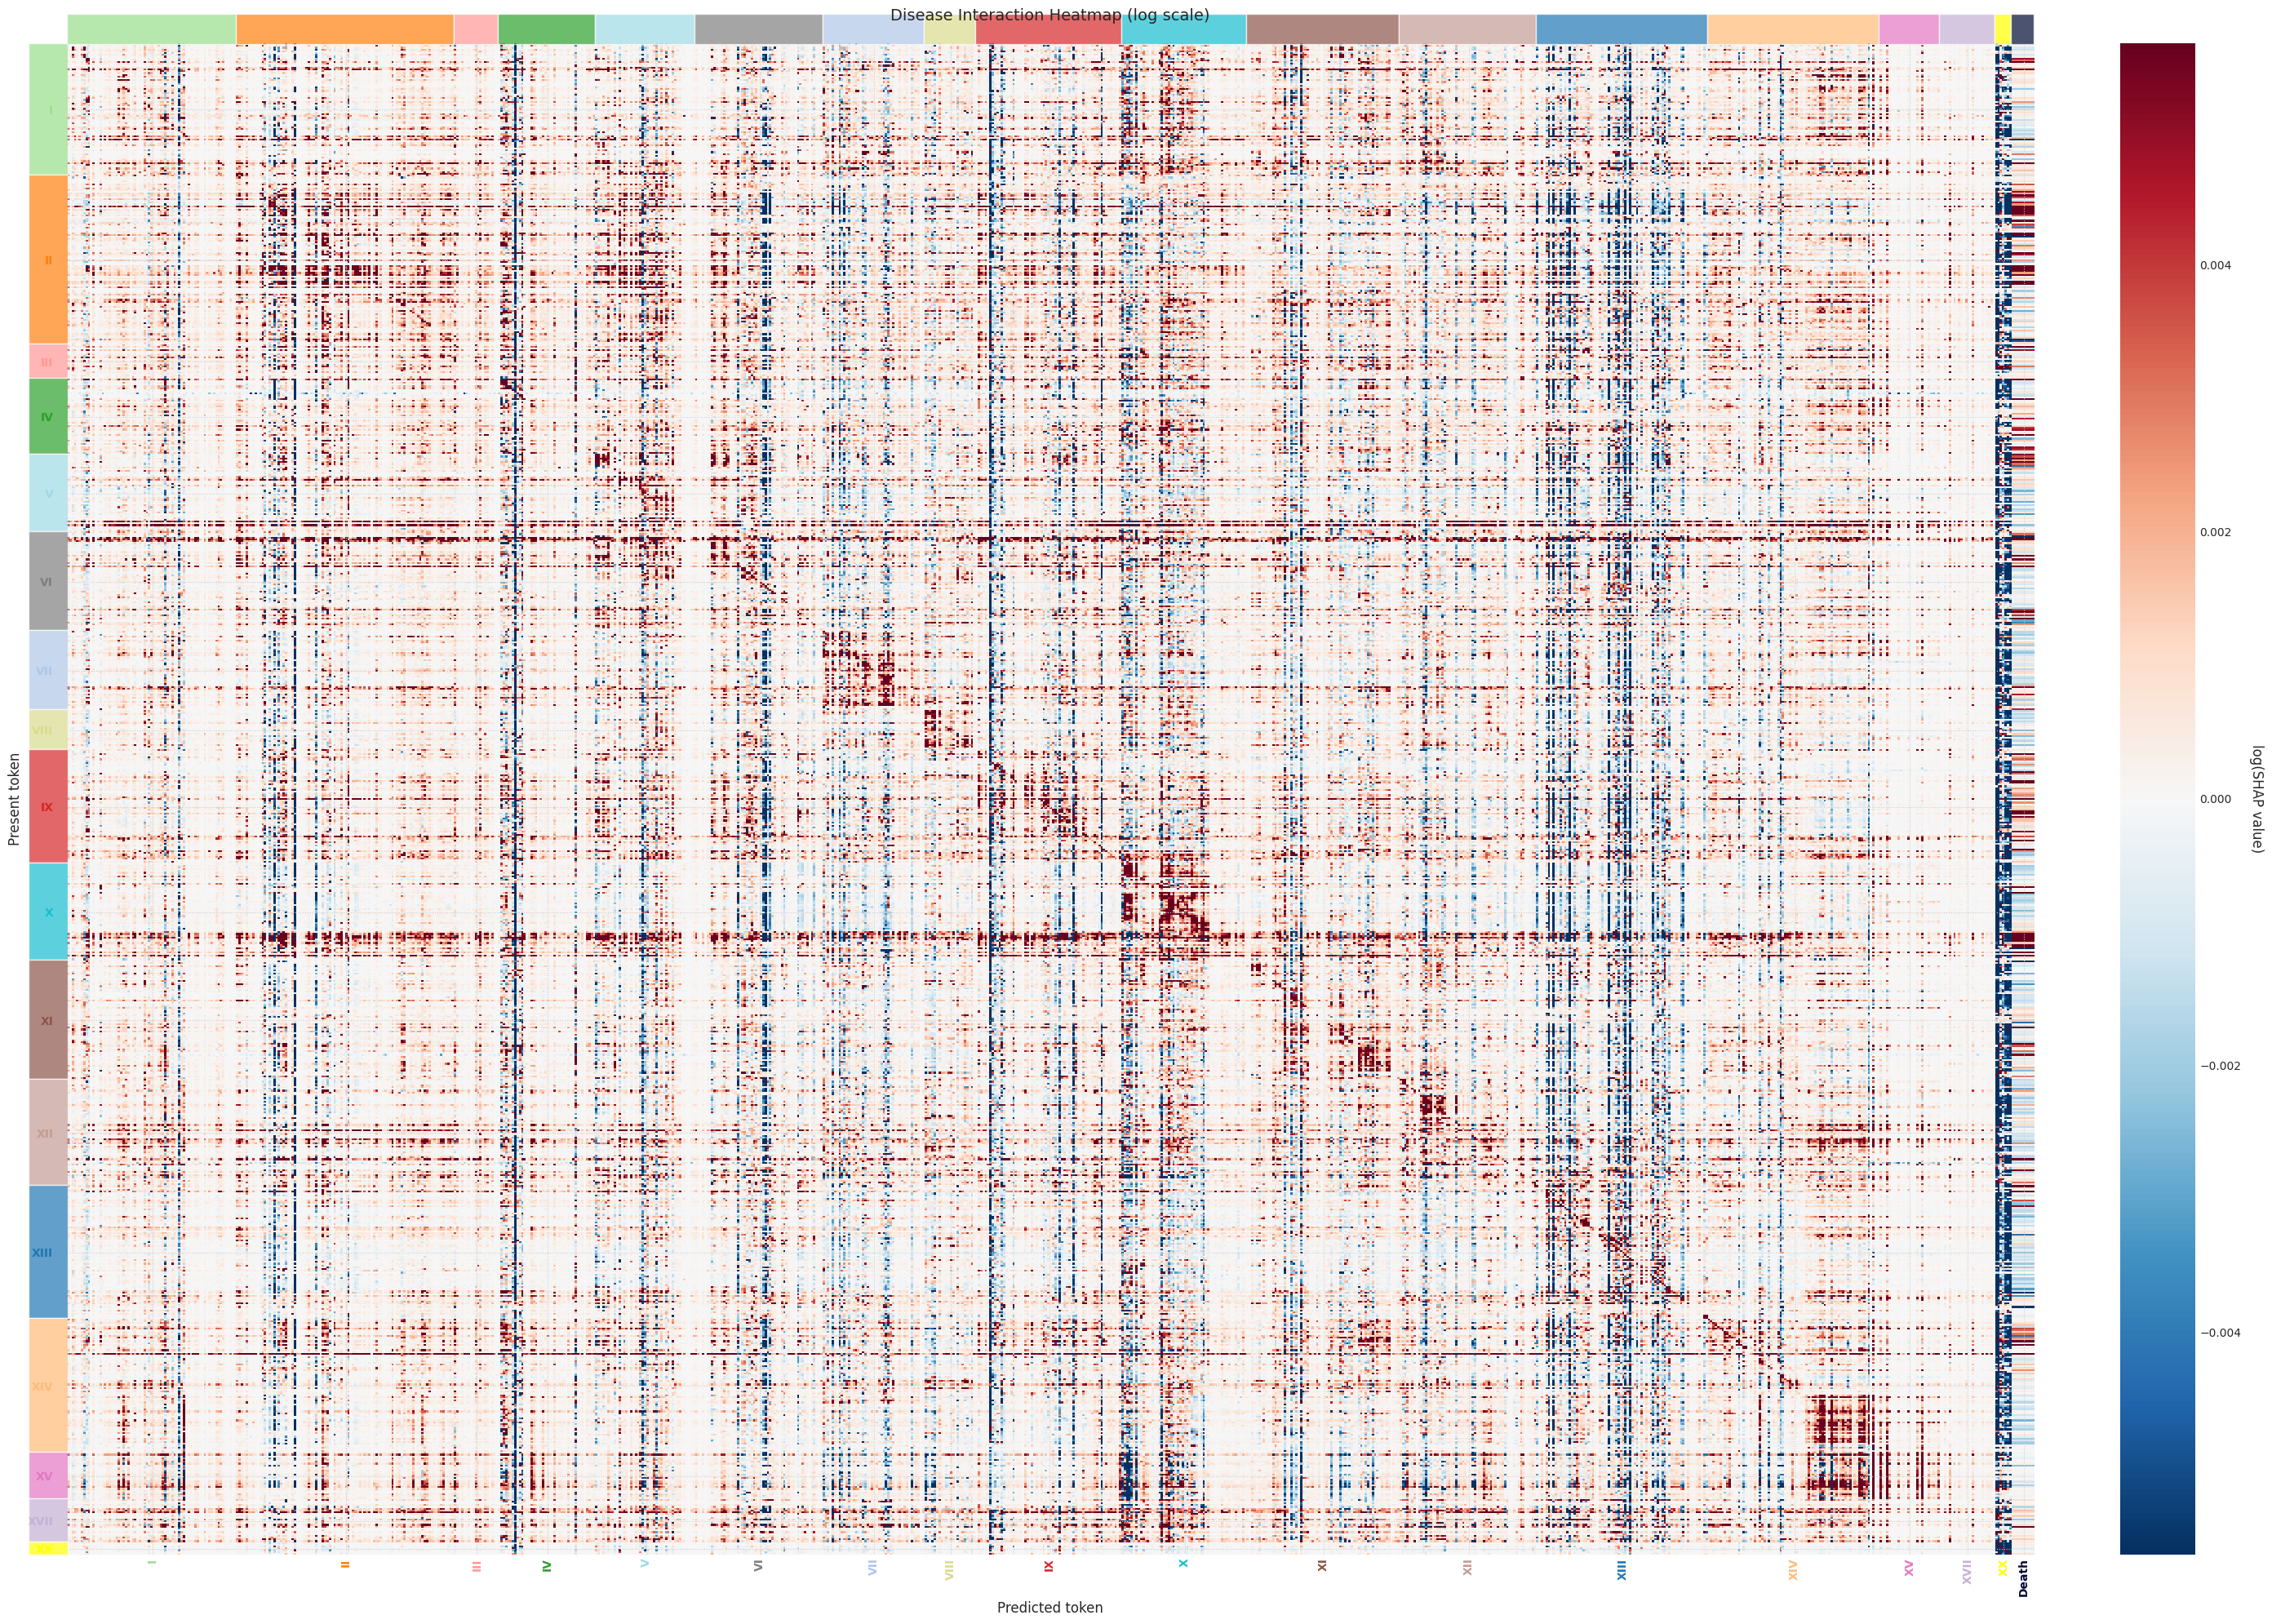

In [15]:
fig = draw_full_heatmap(shap_info, matrix_info, use_log=True)
# fig.savefig('shap_full_heatmap.png', dpi=300, bbox_inches='tight')  # to save


Creating Focused Heatmap (Top 10) (log scale)...


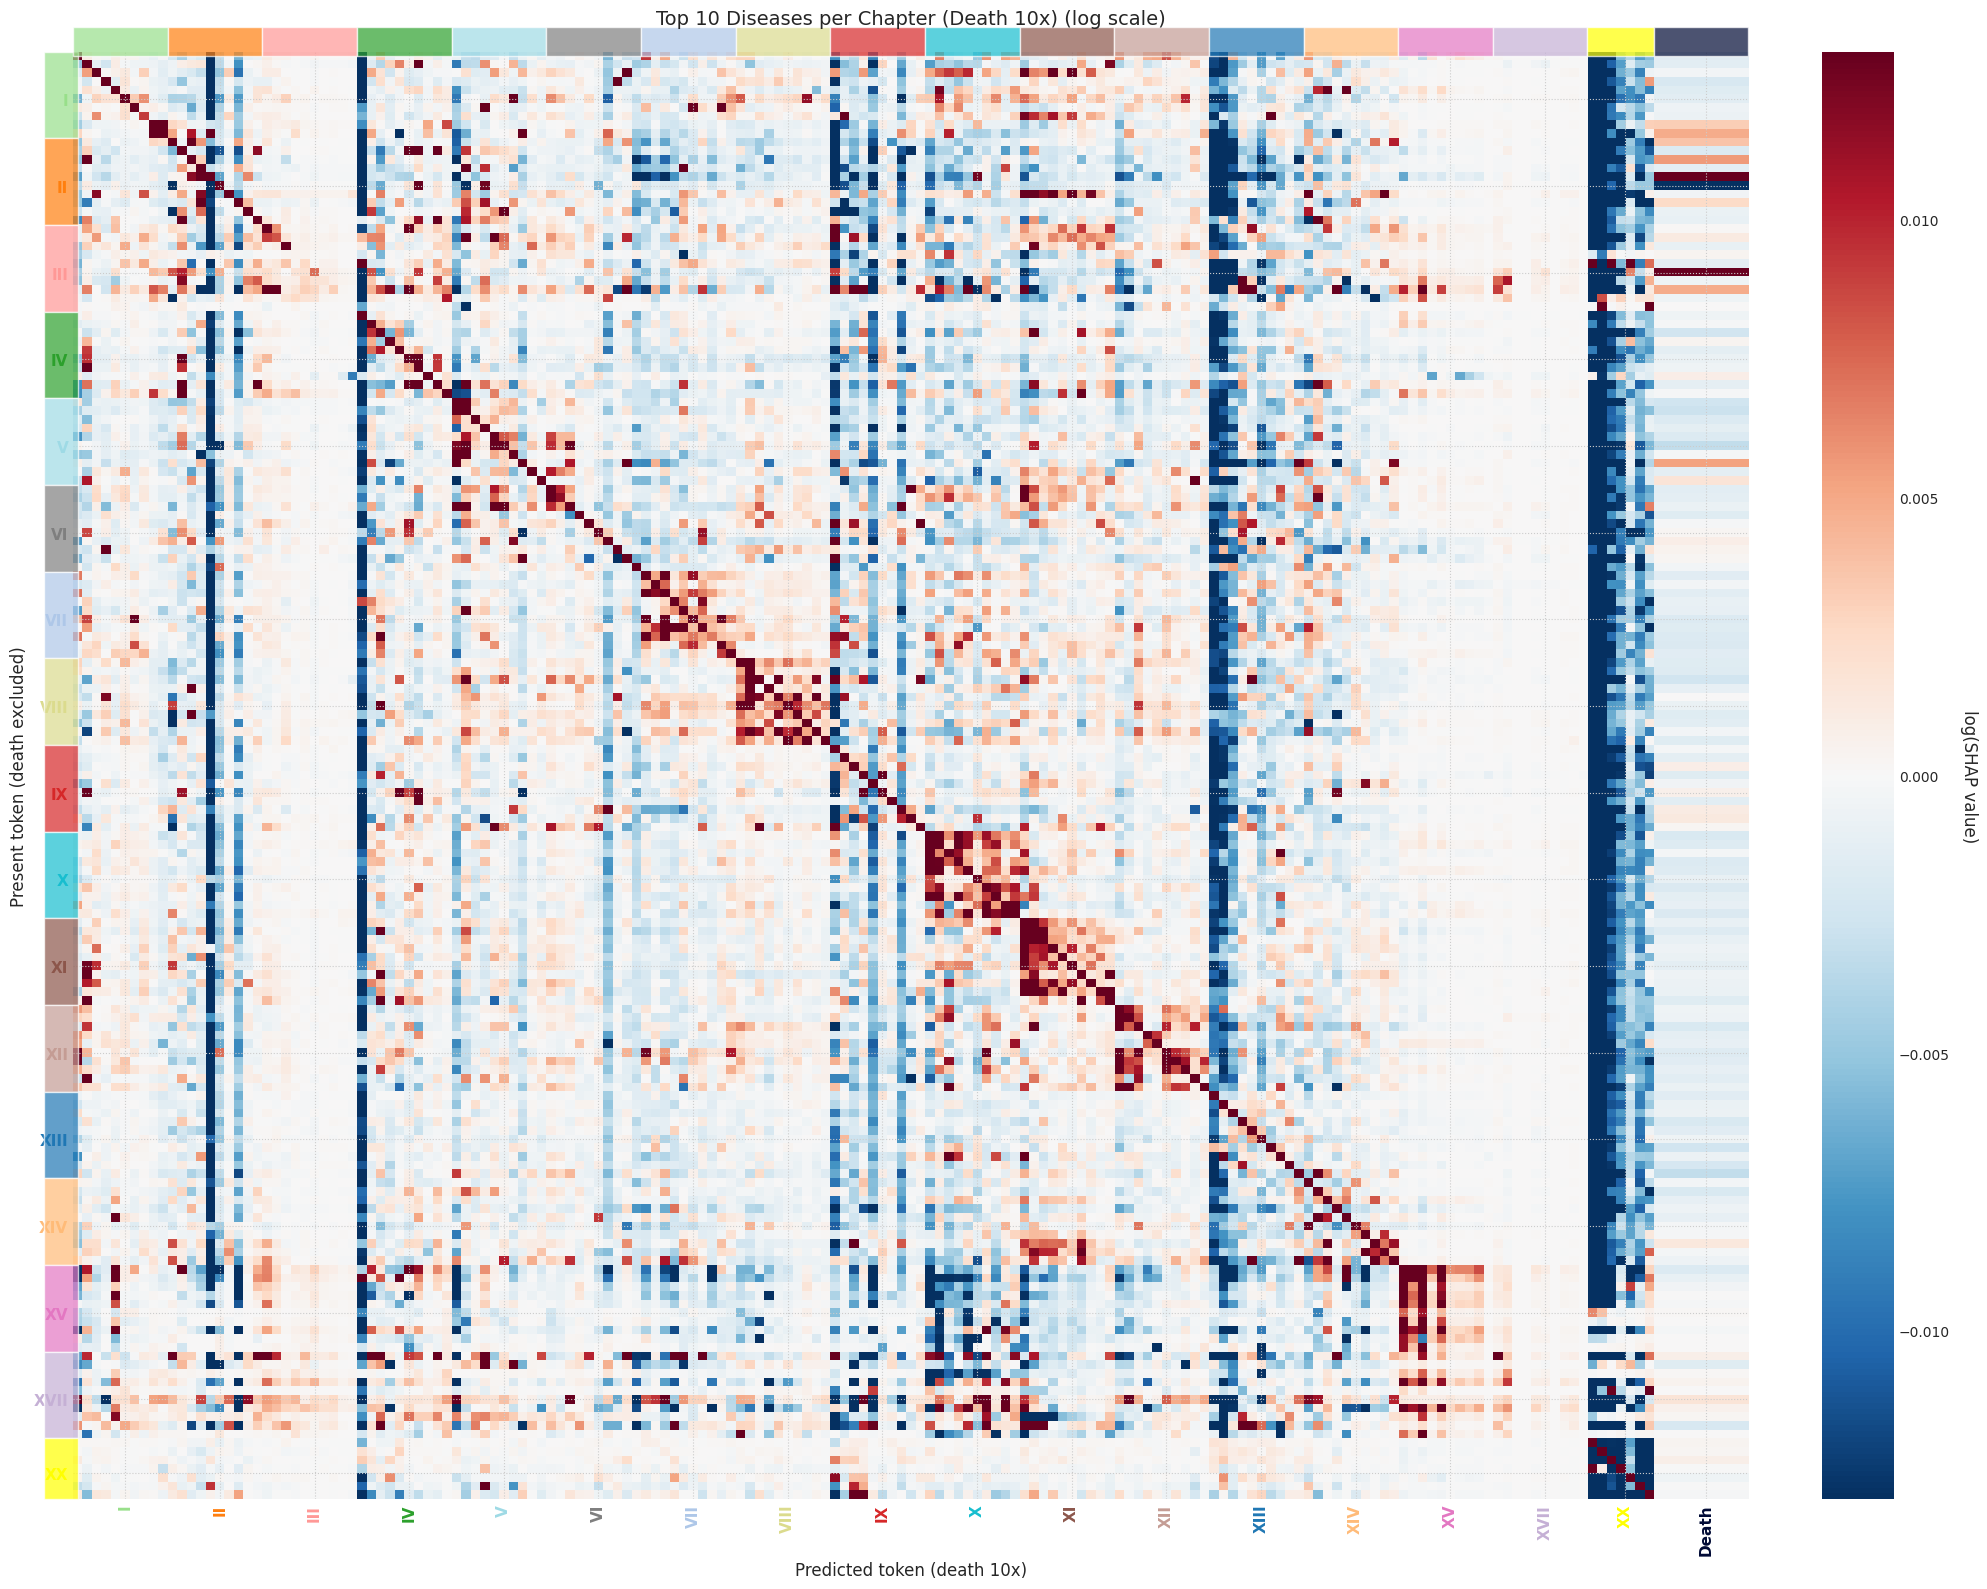

In [16]:
fig = draw_focused_heatmap(shap_info, matrix_info, top_n=10, use_log=True)
# fig.savefig('shap_focused_heatmap.png', dpi=300, bbox_inches='tight')  # to save


Creating Top 20 Interactions (log scale)...


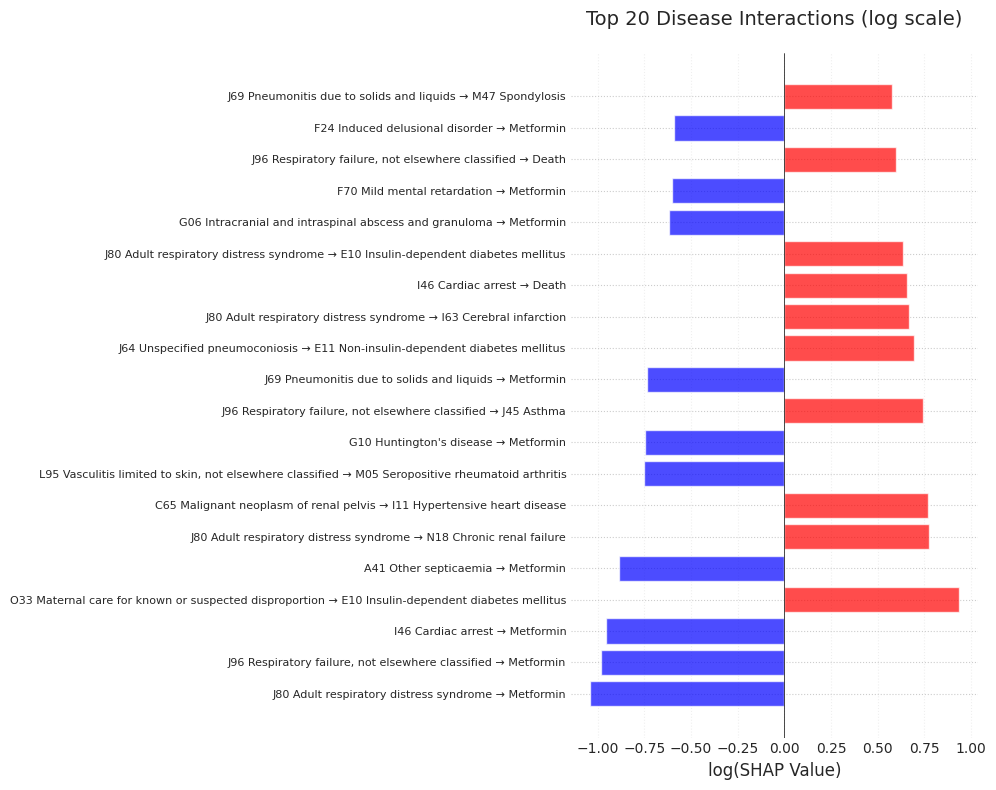

In [17]:
fig = draw_top_interactions(shap_info, matrix_info, top_n=20, use_log=True)
# fig.savefig('shap_top_interactions.png', dpi=300, bbox_inches='tight')  # to save


Creating Chapter-to-Chapter Heatmap  [color: linear]...
  Using linear norm (vmax=0.0003)


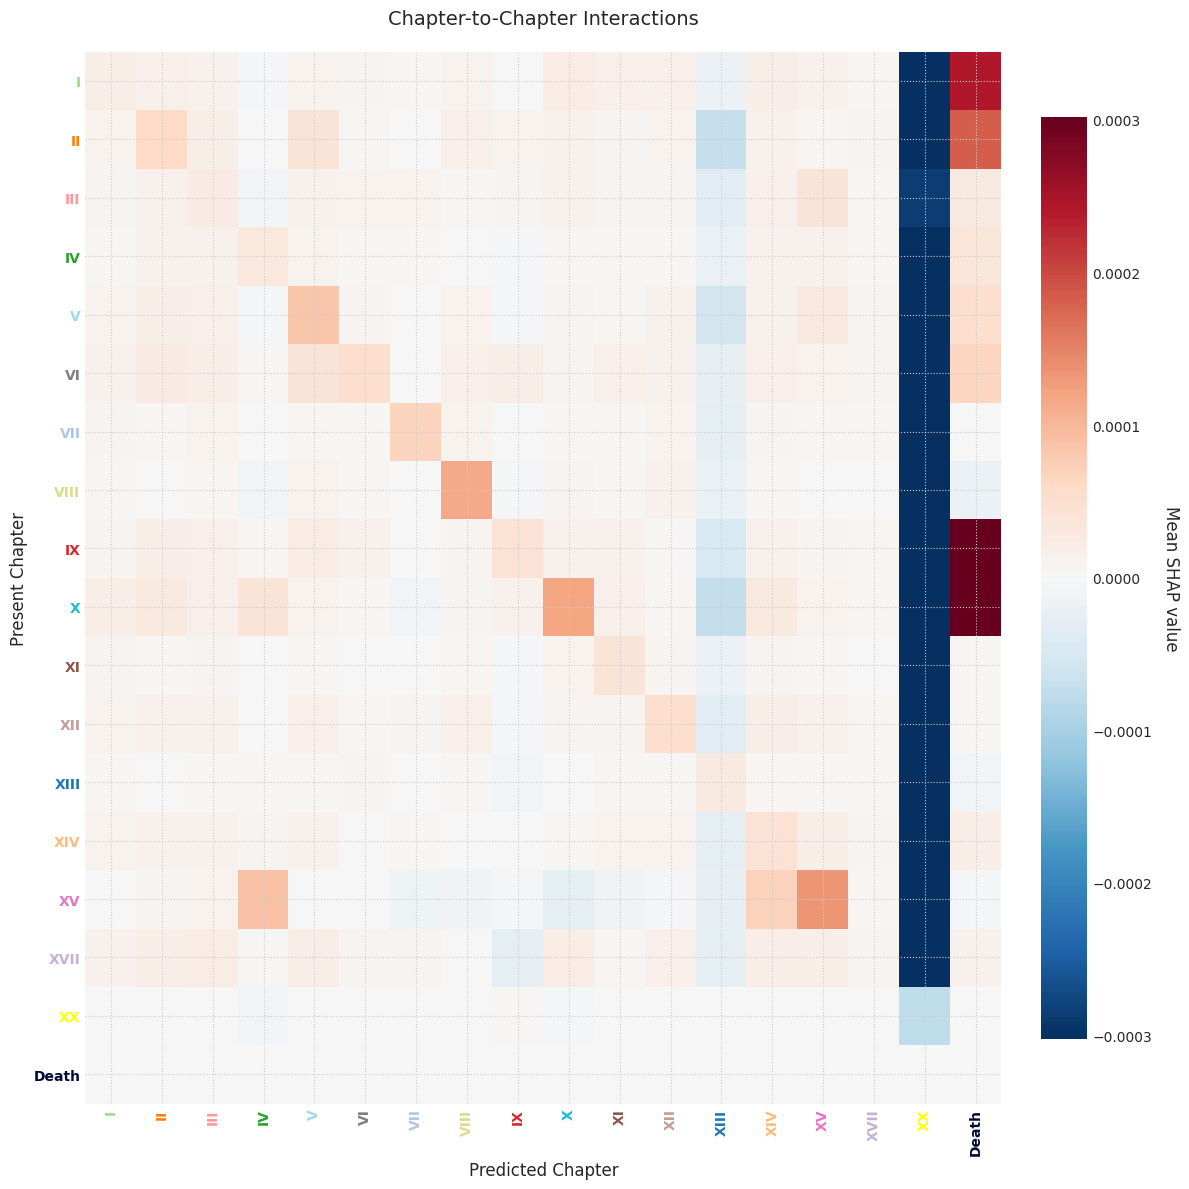

In [24]:
fig = draw_chapter_to_chapter(shap_info, matrix_info, use_log=True, color_mode='linear')
# fig.savefig('shap_chapter_to_chapter.png', dpi=300, bbox_inches='tight')  # to save


Creating Death Risk Factors (Top 10)...
  Total diseases: 839
  Non-zero SHAP values: 833
  SHAP range: [-0.004898, 0.035614]


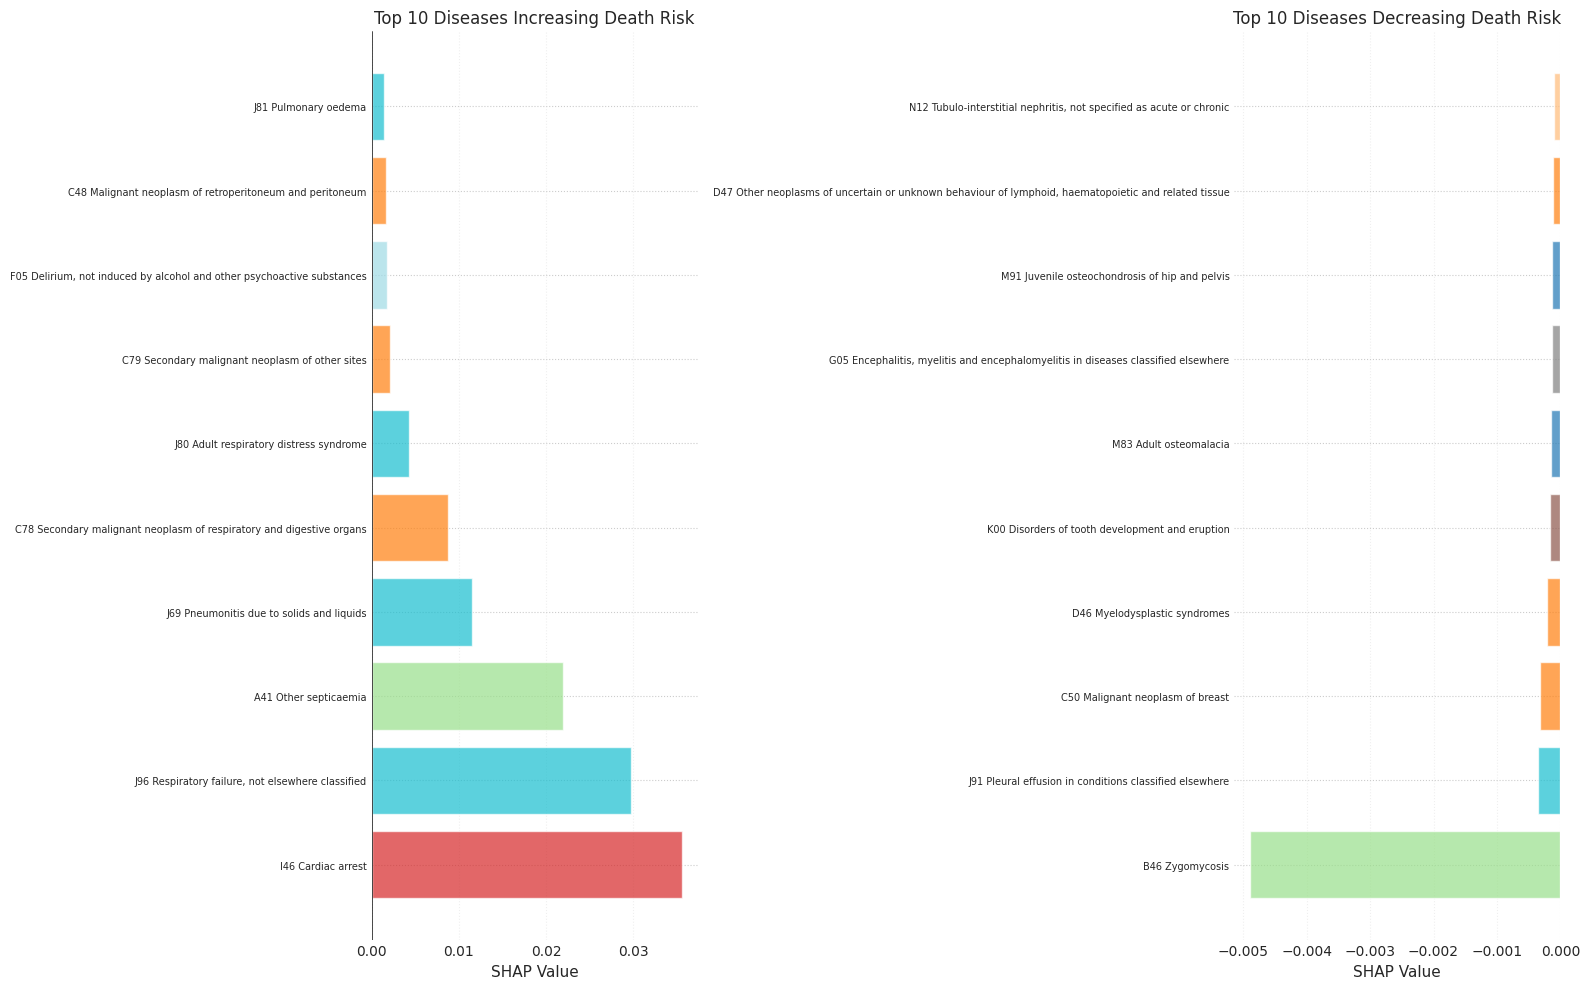

  Top increaser: I46 Cardiac arrest (+0.035614)
  Top decreaser: B46 Zygomycosis (-0.004898)


In [19]:
fig = draw_death_risk_factors(shap_info, matrix_info, top_n=10)
# fig.savefig('shap_death_risk.png', dpi=300, bbox_inches='tight')  # to save


Creating SHAP Distribution...


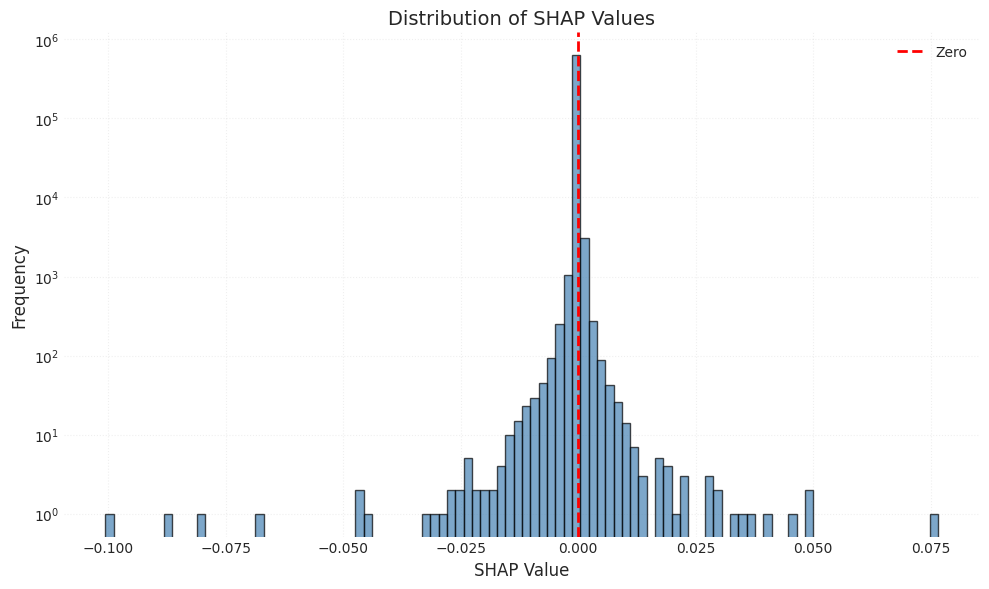

In [20]:
fig = draw_shap_distribution(matrix_info)
# fig.savefig('shap_distribution.png', dpi=300, bbox_inches='tight')  # to save